# Circuit Cutting with Quantum Serverless

**Circuit cutting** is a technique to decompose a quantum circuit into smaller circuits, whose results can be knitted together to reconstruct the original circuit output. 

The circuit knitting toolbox implements a wire cutting method presented in [CutQC](https://doi.org/10.1145/3445814.3446758) (Tang et al.). This method allows a circuit wire to be cut such that the generated subcircuits are amended by measurements in the Pauli bases and by state preparation of four Pauli eigenstates (see Fig. 4 of [CutQC](https://doi.org/10.1145/3445814.3446758)).

This wire cutting technique is comprised of the following basic steps:

1. **Decompose**: Cut a circuit into multiple subcircuits. Here, we'll use an automatic method to find optimal cut(s). See [tutorial 2](tutorial_2_circuit_cutting_manual_cutting.ipynb) to manually cut a circuit.
2. **Evaluate**: Execute those subcircuits on quantum backend(s).
3. **Reconstruct**: Knit the subcircuit results together to reconstruct the original circuit output (in this case, the full probability distribution).

**[Quantum serverless](https://github.com/Qiskit-Extensions/quantum-serverless)** is a platform built to enable distributed computing across a variety of classical and quantum backends.

In this demo, we will show how to use quantum serverless to run portions of your workflows on the cloud.

## Create a quantum circuit with Qiskit

In this case, we'll create a hardware-efficient circuit with two (linear) entangling layers.

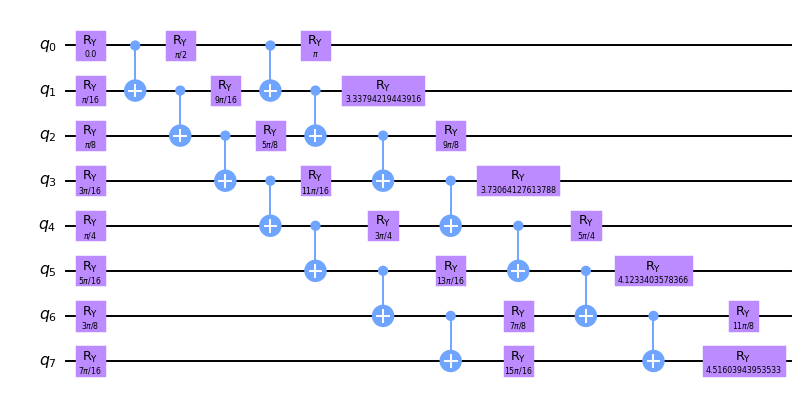

In [1]:
import numpy as np
from qiskit.circuit.library import EfficientSU2

num_qubits = 8
circuit = EfficientSU2(
    num_qubits=num_qubits,
    reps=2,
    entanglement="linear",
    su2_gates=["ry"],
)

circuit = circuit.decompose()

params = [(np.pi * i) / 16 for i in range(len(circuit.parameters))]
circuit = circuit.bind_parameters(params)
circuit.draw("mpl", fold=-1, scale=0.7)

## Set up the Qiskit Runtime Service

The Qiskit Runtime Service provides access to IBM Runtime Primitives and quantum backends.
Alternatively, a local statevector simulator can be used with the Qiskit primitives.

In [2]:
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    Options,
)

# Use local versions of the primitives by default.
service = None

# Uncomment the following line to instead use Qiskit Runtime.
# service = QiskitRuntimeService()

## Set up the QuantumServerless object
 * We will use our local CPU cores as our cluster for this demo
 * We will see commented examples of how one might change the quantum serverless context throughout the workflow

In [3]:
from quantum_serverless import QuantumServerless, get

serverless = QuantumServerless()
serverless.providers()

[<Provider: local>]

## Set the runtime options and backends

The wire cutter tool uses a `Sampler` primitive to evaluate the probabilities of each subcircuit. Here, we configure the options for the Runtime Sampler and specify the backend(s) to be used to evaluate the subcircuits:

In [4]:
# Set the Sampler and runtime options
options = Options(execution={"shots": 4000})

# Run 2 parallel qasm simulator threads
backend_names = ["ibmq_qasm_simulator"] * 2

## Use `quantum-serverless` to send the `cut_circuit_wires` method to a remote cluster

By creating a wrapper function for the `cut_circuit_wires` function and annotating it with the `@run_qiskit_remote()` decorator from `quantum-serverless`, we can send any function to a remote compute cluster. Here, we will create a wrapper function, `cut_circuit_wires_remote`.

In [12]:
from typing import Optional, Sequence, Any, Dict
from nptyping import NDArray
from qiskit import QuantumCircuit
from circuit_knitting_toolbox.circuit_cutting.wire_cutting import cut_circuit_wires
from quantum_serverless import run_qiskit_remote, get

# Create a wrapper function to be sent to remote cluster
@run_qiskit_remote()
def cut_circuit_wires_remote(
    circuit: QuantumCircuit,
    method: str,
    subcircuit_vertices: Optional[Sequence[Sequence[int]]] = None,
    max_subcircuit_width: Optional[int] = None,
    max_subcircuit_cuts: Optional[int] = None,
    max_subcircuit_size: Optional[int] = None,
    max_cuts: Optional[int] = None,
    num_subcircuits: Optional[Sequence[int]] = None,
) -> Dict[str, Any]:
    return cut_circuit_wires(
        circuit=circuit,
        method=method,
        subcircuit_vertices=subcircuit_vertices,
        max_subcircuit_width=max_subcircuit_width,
        max_subcircuit_cuts=max_subcircuit_cuts,
        max_subcircuit_size=max_subcircuit_size,
        max_cuts=max_cuts,
        num_subcircuits=num_subcircuits,
    )

## Decompose the circuit in a serverless context

In this example, we will use an automatic method to find cuts matching our criteria. See [tutorial 2](tutorial_2_circuit_cutting_manual_cutting.ipynb) for how to manually cut a circuit.
   * `method='automatic`: Use a mixed integer programming (MIP) model to find optimal cut(s)
   * `max_subcircuit_width (int)`: Only allow subcircuits with 6 qubits or less
   * `max_cuts (int)`: Cut the circuit no more than two times
   * `num_subcircuits (list)`: The number of subcircuits to try, in this case only 2 subcircuits
   
We will call the `cut_circuit_wires_remote` function within a `QuantumServerless` context, which means it will be run on the specified cluster. Remember, the default cluster for this demo will use the cores on our local CPU. To specify a new cluster, the `QuantumServerless.set_provider` method should be used.

When the remote function is called, it will return a "future" object, and Python will continue interpreting the next line of code. The `get` function from `quantum-serverless` is a blocking command which should be used to retrieve the results of the remote function via the "future" object. The program will not continue past the `get` call until the results of the remote function are returned.

In [8]:
with serverless:
    cuts_future = cut_circuit_wires_remote(
        circuit=circuit,
        method="automatic",
        max_subcircuit_width=5,
        max_cuts=2,
        num_subcircuits=[2],
    )
    cuts = get(cuts_future)

(cut_circuit_wires_remote pid=61078) Exporting as a LP file to let you check the model that will be solved :  inf <class 'float'>
(cut_circuit_wires_remote pid=61078) Version identifier: 22.1.0.0 | 2022-03-27 | 54982fbec
(cut_circuit_wires_remote pid=61078) CPXPARAM_Read_DataCheck                          1
(cut_circuit_wires_remote pid=61078) CPXPARAM_TimeLimit                               300
(cut_circuit_wires_remote pid=61078) Warning:  Non-integral bounds for integer variables rounded.
(cut_circuit_wires_remote pid=61078) Tried aggregator 3 times.
(cut_circuit_wires_remote pid=61078) MIP Presolve eliminated 37 rows and 8 columns.
(cut_circuit_wires_remote pid=61078) MIP Presolve modified 7 coefficients.
(cut_circuit_wires_remote pid=61078) Aggregator did 103 substitutions.
(cut_circuit_wires_remote pid=61078) Reduced MIP has 366 rows, 127 columns, and 1072 nonzeros.
(cut_circuit_wires_remote pid=61078) Reduced MIP has 121 binaries, 6 generals, 0 SOSs, and 0 indicators.
(cut_circu

/Users/caleb/projects/repos_public_acct/circuit-knitting-toolbox/ckt/lib/python3.10/site-packages/ray/_private/worker.py:976: UserWarning: len(ctx) is deprecated. Use len(ctx.address_info) instead.
  warnings.warn("len(ctx) is deprecated. Use len(ctx.address_info) instead.")


**The results from decompose includes information about the wire cutting process, e.g.,**

- `subcircuits`: list of QuantumCircuit objects for the subcircuits
- `complete_path_map`: a dictionary mapping indices of qubits in original circuit to their indices in the subcircuits
- `num_cuts`: the number of times the circuit was cut
- `classical_cost`: the final value of the cost function used to find optimal cut(s)

In [9]:
print(cuts.keys())

dict_keys(['max_subcircuit_width', 'subcircuits', 'complete_path_map', 'num_cuts', 'counter', 'classical_cost'])


**The two subcircuits produced:**

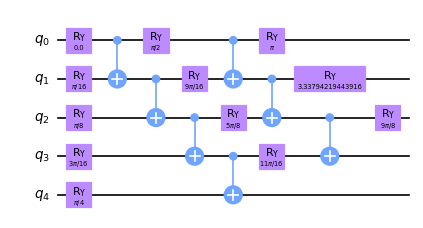

In [10]:
# visualize the first subcircuit
cuts["subcircuits"][0].draw("mpl", fold=-1, scale=0.6)

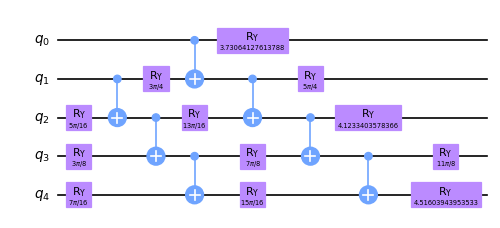

In [11]:
# visualize the second subcircuit
cuts["subcircuits"][1].draw("mpl", fold=-1, scale=0.6)

## Use `quantum-serverless` to send the `evaluate_subcircuits` method to a remote cluster

By creating a wrapper function for the `evaluate_subcircuits` function and annotating it with the `@run_qiskit_remote()` decorator from `quantum-serverless`, we can send any function to a remote compute cluster. Here, we will create a wrapper function, `evaluate_subcircuits_remote`.

In [15]:
from qiskit_ibm_runtime import Options
from circuit_knitting_toolbox.circuit_cutting.wire_cutting import evaluate_subcircuits

# Create a wrapper function to be sent to remote cluster
@run_qiskit_remote()
def evaluate_subcircuits_remote(
    cuts: Dict[str, Any],
    service_args: Optional[Dict[str, Any]] = None,
    backend_names: Optional[Sequence[str]] = None,
    options: Optional[Options] = None,
) -> Dict[int, Dict[int, NDArray]]:
    return evaluate_subcircuits(
        cuts, service_args=service_args, backend_names=backend_names, options=options
    )

## Evaluate the subcircuits with Qiskit Runtime

We will call the `evaluate_subcircuits_remote` function within a `QuantumServerless` context, which means it will be run on the specified cluster. Remember, our local CPU is the default cluster for this demo. To specify a new cluster, the `QuantumServerless.set_provider` method should be used.

When the remote function is called, it will return a "future" object, and Python will continue interpreting the next line of code. The `get` function from `quantum-serverless` is a blocking command which should be used to retrieve the results of the remote function via the "future" object. The program will not continue past the `get` call until the results of the remote function are returned.

In [16]:
with serverless:
    service_args = None if service is None else service.active_account()
    subcircuit_probabilities_future = evaluate_subcircuits_remote(
        cuts,
        service_args=service_args,
        backend_names=backend_names,
        options=options,
    )
    subcircuit_instance_probabilities = get(subcircuit_probabilities_future)

**Inspecting the subcircuit results**

In this case, the original circuit was cut 2 times (we can also get this info from `cuts['num_cuts']`):

In [17]:
print("Number of subcircuits: ", len(subcircuit_instance_probabilities))

Number of subcircuits:  2


From these two wire cuts, there are $4^2=16$ variants of the first subcircuit corresponding to the combination of measurement bases: $P_i\otimes P_j$, for the Paulis $P_i \in \{I, X, Y, Z \}$. And there are $4^2=16$ variants of the second subcircuit corresponding to the combination of initialization states: $|s_i\rangle\otimes|s_j\rangle$, where $|s_i\rangle \in \{ |0\rangle, |1\rangle, |+\rangle |+i\rangle\}$. 


Note that some subcircuit probabilities can be negative (and not sum to unity). This is because the raw probabilities from subcircuits must be modified to account for the measurement bases of ancillary qubits. See Section 3 of [CutQC](https://doi.org/10.1145/3445814.3446758) for more details.

In [18]:
print(
    "Number of variants of 1st subcircuit: ", len(subcircuit_instance_probabilities[0])
)
print(
    "Number of variants of 2nd subcircuit: ", len(subcircuit_instance_probabilities[1])
)

Number of variants of 1st subcircuit:  16
Number of variants of 2nd subcircuit:  16


The first subcircuit has two ancillary qubits (induced by the two wire cuts) that do not appear in the original circuit. This means that the first subcircuit has $5-2=3$ qubits from the original circuit and a probability distribution of size $2^3=8$. The second subcircuit has 5 qubits, all from the original circuit, and so its probability distribution is size $2^5=32$.

In [19]:
print(
    "Size of 1st subcircuit probability distribution: ",
    len(subcircuit_instance_probabilities[0][0]),
)
print(
    "Size of 2nd subcircuit probability distribution: ",
    len(subcircuit_instance_probabilities[1][0]),
)

Size of 1st subcircuit probability distribution:  8
Size of 2nd subcircuit probability distribution:  32


## Use `quantum-serverless` to send the `reconstruct_full_distribution` method to a remote cluster

By creating a wrapper function for the `reconstruct_full_distribution` function and annotating it with the `@run_qiskit_remote()` decorator from `quantum-serverless`, we can send any function to a remote compute cluster. Here, we will create a wrapper function, `reconstruct_full_distribution_remote`.

In [21]:
from circuit_knitting_toolbox.circuit_cutting.wire_cutting import (
    reconstruct_full_distribution,
)


@run_qiskit_remote()
def reconstruct_full_distribution_remote(
    circuit: QuantumCircuit,
    subcircuit_instance_probabilities: Dict[int, Dict[int, NDArray]],
    cuts: Dict[str, Any],
    num_threads: int = 1,
) -> NDArray:
    return reconstruct_full_distribution(
        circuit, subcircuit_instance_probabilities, cuts
    )

## Reconstruct the full circuit output

Next, the results of the subcircuit experiments are classical postprocessed to reconstruct an estimate of the original circuit's full probability distribution.

We will call the `reconstruct_full_distribution_remote` function within a `QuantumServerless` context, which means it will be run on the specified cluster. Remember, our local CPU is the default cluster for this demo. To specify a new cluster, the `QuantumServerless.set_provider` method should be used.

When the remote function is called, it will return a "future" object, and Python will continue interpreting the next line of code. The `get` function from `quantum-serverless` is a blocking command which should be used to retrieve the results of the remote function via the "future" object. The program will not continue past the `get` call until the results of the remote function are returned.

In [22]:
%%capture

with serverless:
    reconstructed_probabilities_future = reconstruct_full_distribution_remote(
        circuit, subcircuit_instance_probabilities, cuts
    )
    reconstructed_probabilities = get(reconstructed_probabilities_future)

Here are the reconstructed probabilities for the original 8-qubit circuit:

In [23]:
print(
    "Size of reconstructed probability distribution: ", len(reconstructed_probabilities)
)

Size of reconstructed probability distribution:  256


## Verify the results

If the original circuit is small enough, we can use a statevector simulator to check the results of cutting against the original circuit's exact probability distribution (ground truth).

In [24]:
from circuit_knitting_toolbox.circuit_cutting.wire_cutting import verify

metrics, exact_probabilities = verify(circuit, reconstructed_probabilities)

The verify step includes several metrics, including the chi square loss. More info about each metric can be found in the [utils metrics file](https://github.com/Qiskit-Extensions/circuit-knitting-toolbox/blob/main/circuit_knitting_toolbox/utils/metrics.py).

In [25]:
metrics

{'nearest': {'chi2': 0.017792257444297577,
  'Mean Squared Error': 5.529897101754817e-07,
  'Mean Absolute Percentage Error': 173368.20660547732,
  'Cross Entropy': 3.703677425126872,
  'HOP': 0.9927044006502894},
 'naive': {'chi2': 0.016632831851813537,
  'Mean Squared Error': 5.469000610963171e-07,
  'Mean Absolute Percentage Error': 175952.4694512566,
  'Cross Entropy': 3.662330531928901,
  'HOP': 0.9895921544750793}}

If we calculated the ground truth above, we can visualize a comparison to the reconstructed probabilities

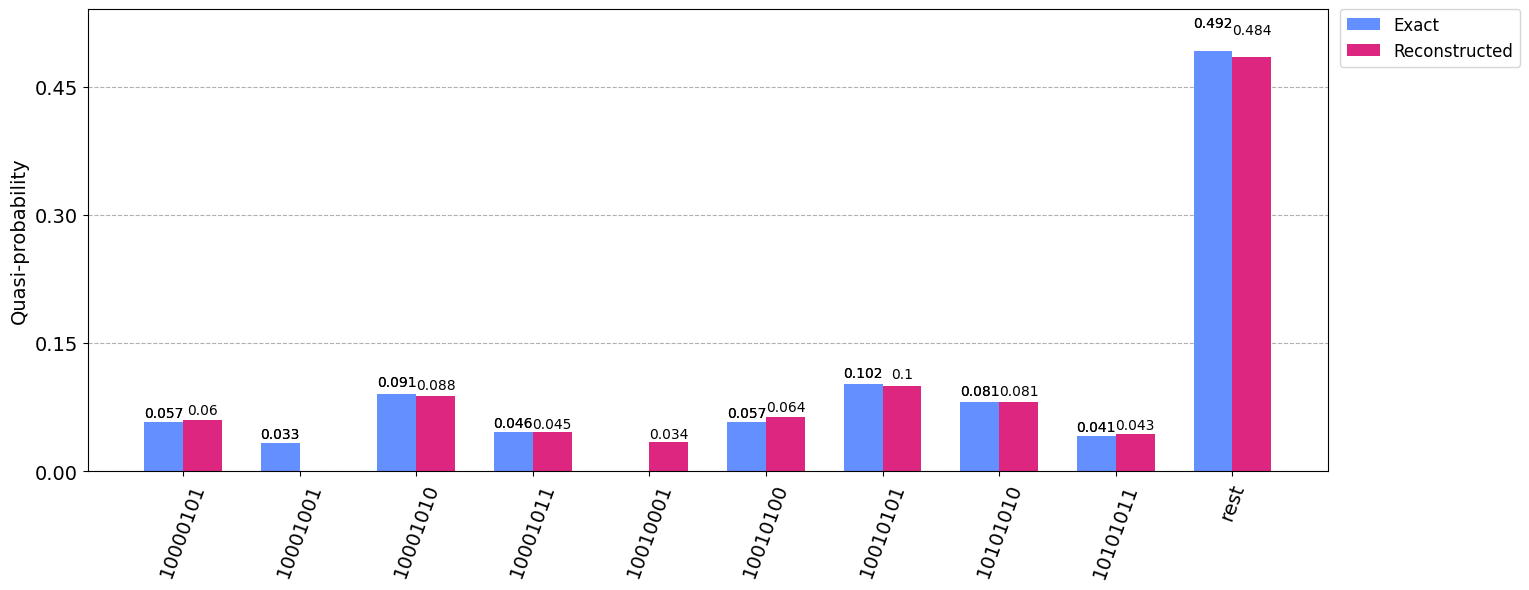

In [26]:
from qiskit.visualization import plot_histogram
from qiskit.result import ProbDistribution

# Create a dict for the reconstructed distribution
reconstructed_distribution = {
    i: prob for i, prob in enumerate(reconstructed_probabilities)
}

# Represent states as bitstrings (instead of ints)
reconstructed_dict_bitstring = ProbDistribution(
    data=reconstructed_distribution
).binary_probabilities(num_bits=num_qubits)


# Create the ground truth distribution dict
exact_distribution = {i: prob for i, prob in enumerate(exact_probabilities)}

# Represent states as bitstrings (instead of ints)
exact_dict_bitstring = ProbDistribution(data=exact_distribution).binary_probabilities(
    num_bits=num_qubits
)

# plot a histogram of the distributions
plot_histogram(
    [exact_dict_bitstring, reconstructed_dict_bitstring],
    number_to_keep=8,
    figsize=(16, 6),
    sort="asc",
    legend=["Exact", "Reconstructed"],
)

In [27]:
import qiskit.tools.jupyter

%qiskit_version_table

This code is a Qiskit project.
© Copyright IBM 2022.

This code is licensed under the Apache License, Version 2.0. You may
obtain a copy of this license in the LICENSE.txt file in the root directory
of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.

Any modifications or derivative works of this code must retain this
copyright notice, and modified files need to carry a notice indicating
that they have been altered from the originals.